<a href="https://colab.research.google.com/github/mlexchange/als_ml_tutorial/blob/main/2_1_ML_tutorial_DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

## Import Packages

In [1]:
import os
import glob
import numpy as np
from PIL import Image
from PIL import ImageOps
import skimage
from skimage import io
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt

## Load Your Data

In [2]:
data_directory = '/content/drive/MyDrive/Code/preprocessing/data_64x64_400/'

One of the option to load all images in your directory is by `glob.glob` function.

In [3]:
filenames = glob.glob(data_directory + '*.jpg') # '*' is the wildcard which refers to all jpg files within the directory
print(f'Number of images: {len(filenames)}')
print('first 5:')
print(filenames[:5])

Number of images: 400
first 5:
['/content/drive/MyDrive/Code/preprocessing/data_64x64_400/000008.jpg', '/content/drive/MyDrive/Code/preprocessing/data_64x64_400/000038.jpg', '/content/drive/MyDrive/Code/preprocessing/data_64x64_400/000015.jpg', '/content/drive/MyDrive/Code/preprocessing/data_64x64_400/000010.jpg', '/content/drive/MyDrive/Code/preprocessing/data_64x64_400/000005.jpg']


You see filenames are not appeared in the order we would expect. If you want to load them in the desired order, there is a sort function available.

In [4]:
filenames = sorted(filenames)
print('first 5:')
print(filenames[:5])

first 5:
['/content/drive/MyDrive/Code/preprocessing/data_64x64_400/000001.jpg', '/content/drive/MyDrive/Code/preprocessing/data_64x64_400/000002.jpg', '/content/drive/MyDrive/Code/preprocessing/data_64x64_400/000003.jpg', '/content/drive/MyDrive/Code/preprocessing/data_64x64_400/000004.jpg', '/content/drive/MyDrive/Code/preprocessing/data_64x64_400/000005.jpg']


Next we load all images according to their name. There are a bunch of options to do so.

Both **PIL.Image** (Python Imaging Library) and **skimage** (scikit-image) are popular libraries for image processing in Python, but they serve slightly different purposes and have different strengths. The choice between them depends on your specific needs and the complexity of your tasks. In some cases, you might even find it beneficial to use both libraries together.

### Using PIL.Image

**PIL.Image** is a powerful library for basic image processing tasks, such as opening, saving, and manipulating images.


**When** should I use? If you're primarily dealing with simple image manipulation, like resizing, cropping, rotating, and want an easy-to-use library.

In [5]:
images = [] # We first create an empty list as a placeholder for all image arrays
for img_name in filenames:
    img = Image.open(img_name) # Read the image
    images.append(img) # Append to the placeholder we created

Let's take a look for one example image we just loaded:

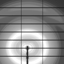

In [6]:
images[0] # Remember, python starts from 0, so this is the first image in our collection.

### Using skimage

**scikit-image (skimage)** is an image processing library that provides a wide range of advanced image processing algorithms and functions. Also it is built on top of NumPy and SciPy, making it great for scientific image analysis and research.

**When** should I use? If you need to perform more sophisticated image processing techniques or need access to a variety of algorithms.

In [7]:
images = [] # A placeholder

for img_name in filenames:
  img = io.imread(img_name) # imread will load the image as a numpy array, which we will see shortly.
  images.append(img)

images = np.array(images) # We convert the list into a numpy array stack for easier processing later

## Investigate Your Data

Before you start with processing, it's always good to do a quick check if you have loaded exactly what you need.

Let's take a look for the numpy stack `images` we just loaded with skimage, you can use `shape` to check the dimension of the array:

In [8]:
images.shape

(400, 64, 64)

This means we have 400 images in this stack, each of them is 64 by 64 size. Take the first image as an example:

In [9]:
images[0]

array([[ 56,  56,  57, ...,  53,  52,  52],
       [ 57,  57,  58, ...,  53,  53,  51],
       [ 57,  59,  60, ...,  53,  53,  53],
       ...,
       [122, 135, 140, ...,  77,  77,  77],
       [117, 128, 136, ...,  77,  77,  77],
       [114, 119, 132, ...,  77,  77,  77]], dtype=uint8)

You see the image is represented as a 2D numpy array, with each element value referring to the pixel intensity, in the format of uint8.

What is **uint8**? It stands for "unsigned 8-bit integer": In short it's a memory efficient way to represent whole numbers that range from 0 to 255, which is perfect for the pixel value. The term "unsigned" indicates that the integer can only hold non-negative values.

Now some visualizations:


In [10]:
print(f'Min pixel intensity: {np.min(images[0])}, Max pixel intensity: {np.max(images[0])}')

Min pixel intensity: 28, Max pixel intensity: 255


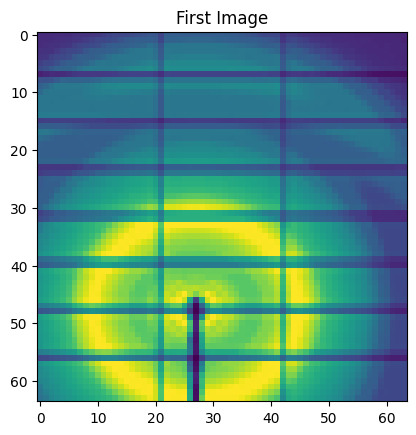

In [11]:
plt.imshow(images[0])
plt.title('First Image')
plt.show()

Don't worry about the color, it's the `viridis` colormap in matplotlib default settings. We are still dealing with grayscale images in our case.

Now let's take a look for the first 10 images in our dataset, and using grayscale colorbar:

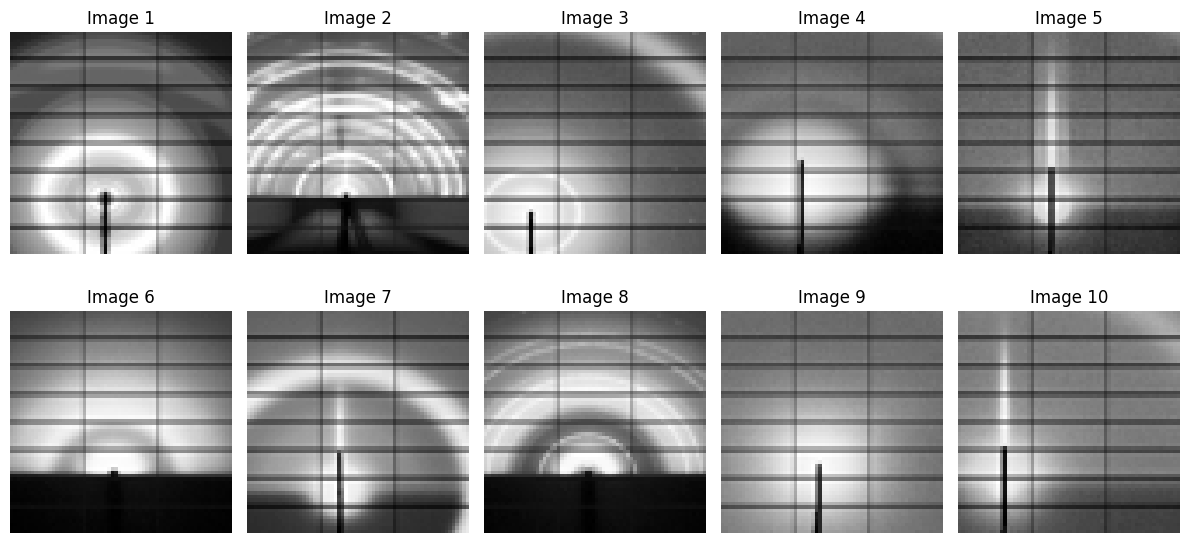

In [12]:
num_images_to_plot = 10

plt.figure(figsize=(12, 6))
for i in range(num_images_to_plot):
    plt.subplot(2, 5, i + 1)  # Create a 2x5 grid of subplots
    plt.imshow(images[i], cmap = 'gray')
    plt.title(f"Image {i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Image Oriented Processing in Numpy fashion

### Grayscale Conversion

The fist thing to consider here is that: do you have **grayscale** image (black and white), or **colored** image (RGB)?

The second thing to consider here: if you deal with **RGB** images, does each channel have specific information for your analysis?

If the answer is no, you should consider converting your RGB images to grayscale before feed into the neural networks.

**Why**? It reduces the channel / pixel values needed to proceed, saves memory and computation.

In our case, since the dataset is already in grayscale, we don't need to worry about it. But if you would like to convert RGB to grayscale, one example you could use is by

In our case, since the dataset is already in grayscale, we don't need to worry about it. But if you would like to convert RGB to grayscale, one example you could use is by **skimage**:

`gray_image = skimage.color.rgb2gray(RGB_image)`

### Normalization

This step is somehow critical in deep learning.

**What** is normalization? It rescales the pixel intensity of all your images into a predefined range, it could be (0, 1), (-1, 1) in most cases.

Why do we need that? Two major reasons behind:

1. It will make it **fair to compare** across datasets. Because neural networks may asign dominating weights for those with bigger scales or units without normalization.

2. It will make the pipeline more **robust** and help the learning converge faster due to the gradient descent nature used in the training process.

Various normalization methods can be used in this step. Below we introduce two common methods and compute them mathmatically in numpy array manner if you want to know what exactly happen to the data. Note that these steps can also be done in built-in functions in pytorch easily, and we will show that shortly too.

#### Min-Max Normalization

Oftenly called just by normalization by people, this method **scales to [0, 1]** by shifting the pixel value by the min pixel in image, and devide by the range.

In [13]:
def min_max_normalize(image):

    min_val = np.min(image)
    max_val = np.max(image)
    print(f'Min pixel value in image: {min_val}')
    print(f'Max pixel value in image: {max_val}')

    print('------------------')
    normalized_image = (image - min_val) / (max_val - min_val)
    print(f'Min pixel value in normalized image: {np.min(normalized_image)}')
    print(f'Max pixel value in normalized image: {np.max(normalized_image)}')

    return normalized_image

In [14]:
image_example = images[0]
normed = min_max_normalize(image_example)

Min pixel value in image: 28
Max pixel value in image: 255
------------------
Min pixel value in normalized image: 0.0
Max pixel value in normalized image: 1.0


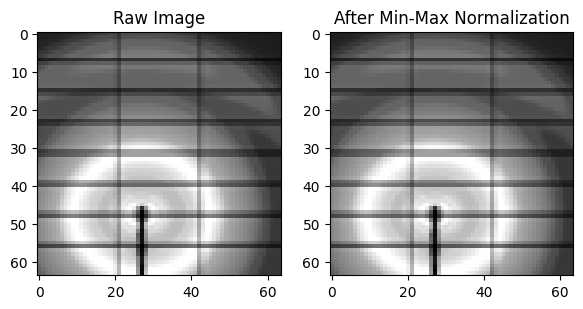

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(image_example, cmap = 'gray')
axes[0].set_title('Raw Image')

axes[1].imshow(normed, cmap = 'gray')
axes[1].set_title('After Min-Max Normalization')

plt.tight_layout()

plt.show()

As you can see, this method won't change the brightness / contrast of your image, but the data has been mapped into a confined range.

#### Mean and Standard Deviation Normalization

Also has names as **data standardization** or **z-score normalization**.

This method normalizes the pixel values to have a **mean of 0** and a **standard deviation of 1**.

**How**? shift by mean and divide by standard deviation.

In [16]:
def standardize(image):

    mean = np.mean(image)
    std = np.std(image)
    print(f'Min pixel value in image: {np.min(image)}')
    print(f'Max pixel value in image: {np.max(image)}')
    print(f'Mean in image: {mean}')
    print(f'Standard deviation in image: {std}')

    print('------------------')

    standardized_image = (image - mean) / std
    print(f'Min pixel value in standardized_image: {np.min(standardized_image)}')
    print(f'Max pixel value in standardized_image: {np.max(standardized_image)}')
    print(f'Mean in standardized_image: {np.mean(standardized_image)}')
    print(f'Standard deviation in standardized_image: {np.std(standardized_image)}')

    return standardized_image

In [17]:
image_example = images[0]
standardized = standardize(image_example)

Min pixel value in image: 28
Max pixel value in image: 255
Mean in image: 141.488525390625
Standard deviation in image: 56.297595880526636
------------------
Min pixel value in standardized_image: -2.0158680600050407
Max pixel value in standardized_image: 2.0162757011909753
Mean in standardized_image: 0.0
Standard deviation in standardized_image: 1.0


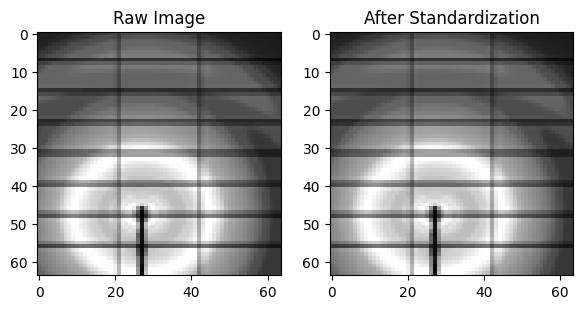

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(image_example, cmap = 'gray')
axes[0].set_title('Raw Image')

axes[1].imshow(standardized, cmap = 'gray')
axes[1].set_title('After Standardization')

plt.tight_layout()

plt.show()

The standardization preserves the feature in your image.

### Other techniques

There are lots of techniques we can apply to the image dataset in order to augment the performance of the training. These can be done in a numpy way using packages in **skimage** library to achieve resizing, cropping, flipping ... But you will see that **pytorch** also have handy tools to perform such tasks and it's easy to use.

## Convert Data into Tensors and Perform Augmentation in Pytorch

Since this workshop will be demonstrated mainly using Pytorch. We will need to know how to get your data into the friendly format - **Tensors**.

### Load data into Tensor Format

**What** is tensor? If you come with some math background, please don't be confused. In PyTorch, we use tensors as a specialized data structure that are very similar to arrays and matrices to encode the inputs and outputs of a model, as well as the model’s parameters.

Tensors are similar to NumPy’s ndarrays, except that tensors can run on GPUs or other hardware accelerators.

You can directly pass in your array-like data into the `torch.tensor()` function, and the data format (in our case, uint8) will be automatically inferred.

In [19]:
 images_tensor= torch.tensor(images)
 images_tensor

tensor([[[ 56,  56,  57,  ...,  53,  52,  52],
         [ 57,  57,  58,  ...,  53,  53,  51],
         [ 57,  59,  60,  ...,  53,  53,  53],
         ...,
         [122, 135, 140,  ...,  77,  77,  77],
         [117, 128, 136,  ...,  77,  77,  77],
         [114, 119, 132,  ...,  77,  77,  77]],

        [[176, 120, 100,  ...,  97,  87,  81],
         [131, 113, 107,  ...,  94,  87,  81],
         [105, 110, 110,  ...,  93,  92,  90],
         ...,
         [ 20,  21,  23,  ...,  50,  52,  56],
         [ 22,  23,  22,  ...,  26,  28,  33],
         [ 22,  21,  22,  ...,  20,  20,  21]],

        [[150, 146, 139,  ..., 109,  97,  96],
         [133, 128, 127,  ..., 100,  99,  98],
         [118, 118, 115,  ..., 100, 100, 100],
         ...,
         [209, 211, 217,  ..., 103, 100,  98],
         [207, 209, 211,  ..., 100,  99,  98],
         [205, 207, 208,  ..., 101, 100, 102]],

        ...,

        [[130, 132, 133,  ...,  83,  83,  83],
         [135, 138, 139,  ...,  84,  83,  83]

In [20]:
print(f'Tensor shape: {images_tensor.shape}')

Tensor shape: torch.Size([400, 64, 64])


You can see the information matches what we have seen in numpy fashion. 400 images with 64 by 64 pixels per image.

In our case, since we are dealing with grayscale images, the channel is 1. When you are dealing with colored images, or need to perform feature extraction methods, you will need to expand a seperate dimension to store the channel information. For clarity we add the channel here, usually as the 2nd element displayed in 4D tensor shape.

In [21]:
images_tensor = images_tensor.unsqueeze(1) # Remember python starts at 0.
print(f'New tensor shape: {images_tensor.shape}')

New tensor shape: torch.Size([400, 1, 64, 64])


Alternatively, if you want to pre-expand your numpy array and pass into the tensor, it's also doable by using the `np.expand_dims()` function.

In [22]:
print(f'Numpy array shape: {images.shape}')
images_expanded = np.expand_dims(images, axis = 1) # Expand the dimension at the 2nd axis, since our first axis referrs to the number of images

print(f'After expansion: {images_expanded.shape}')
images_expanded_tensor = torch.tensor(images_expanded)

print(f'Tensor shape remains the same as above: {images_expanded_tensor.shape}')

Numpy array shape: (400, 64, 64)
After expansion: (400, 1, 64, 64)
Tensor shape remains the same as above: torch.Size([400, 1, 64, 64])


If you want to know more about tensors, here is a good starting point: [PyTorch Tensor](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html)

### Using `torchvision.transforms` to Manipulate Data

`torchvision.transforms` is a handy module within the PyTorch ecosystem that provides a set of transformations that can be applied to image data. These transformations are commonly used to preprocess and augment images before feeding them into neural networks for tasks such as image classification, object detection, and more.

Another good thing about this package is that it allows you to concatenate multiple steps in one by using the `Compose()` function. Here is a simple example:

In [23]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),                       # Convert to tensor, this step automatically adds the channel info as the first dimension,
                                                 # and rescales the data to [0,1].
])

In [24]:
image_example = images[0]
print(f'Image Shape: {image_example.shape}')
print(f'Min: {np.min(image_example)}, Max: {np.max(image_example)}')
tensor_image = transform(image_example)
print(f'Tensor Image Shape: {tensor_image.shape}')
print(f'Min: {torch.min(tensor_image)}, Max: {torch.max(tensor_image)}')

Image Shape: (64, 64)
Min: 28, Max: 255
Tensor Image Shape: torch.Size([1, 64, 64])
Min: 0.10980392247438431, Max: 1.0


What if you want to rescale your data to [-1, 1]? One way to "cheat" is to use `transforms.Normalize()` with mean and std of 0.5 and 0.5. The min value will become (0-0.5)/0.5 = -1 and max will become (1-0.5)/0.5 = 1.

In [25]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),                       # Convert to tensor, this step automatically adds the channel info as the first dimension,
                                                 # and rescales the data to [0,1].
    transforms.Normalize(mean=[0.5], std=[0.5]), # Standardize the data with given mean and std, pytorch uses Mean and Standard Deviation Normalization.
])

In [26]:
image_example = images[0]
print(f'Image Shape: {image_example.shape}')
print(f'Min: {np.min(image_example)}, Max: {np.max(image_example)}')
tensor_image = transform(image_example)
print(f'Tensor Image Shape: {tensor_image.shape}')
print(f'Min: {torch.min(tensor_image)}, Max: {torch.max(tensor_image)}')

Image Shape: (64, 64)
Min: 28, Max: 255
Tensor Image Shape: torch.Size([1, 64, 64])
Min: -0.7803921699523926, Max: 1.0


If you pass in the mean and std of the image itself, it will standardize your image to have mean of 0 and std of 1 respectively.

Now, if we start from the very beginning, with our raw data in folder. The pipeline will look like:

In [27]:
# Define Data Directory
data_directory = '/content/drive/MyDrive/Code/preprocessing/data_64x64_400/'

# Read filenames
filenames = glob.glob(data_directory + '*.jpg') # '*' is the wildcard which refers to all jpg files within the directory
filenames = sorted(filenames) # This step is not necessary, but if you want the image in your stack to be appeared into a desired order, do so.
print(f'Number of images: {len(filenames)}')

dataset = [] # A placeholder

for img_name in filenames:
  img = io.imread(img_name) # Read image as numpy array, could use PIL too.
  # We need the mean and std for standardization, recall ToTensor() will scale [0, 255] to [0, 1], we divide by 255 to accompany that.
  mean = np.mean(img) / 255
  std = np.std(img) / 255
  # Define transformations
  transform = transforms.Compose([
      transforms.ToTensor(),                       # Convert to tensor, channel will be taken care of automatically
      transforms.Normalize(mean = [mean], std = [std]), # Normalize the data, pytorch uses Mean and Standard Deviation Normalization by default.
  ])

  # Apply transformation
  img_tensor = transform(img)

  # Append to the dataset list
  dataset.append(img_tensor)

# Stack the dataset to form the 4D array we saw
dataset = torch.stack(dataset)
print(f'Dataset Shape: {dataset.shape}')
dataset = TensorDataset(dataset)


Number of images: 400
Dataset Shape: torch.Size([400, 1, 64, 64])


Take a look at the first tensor image to double check:

In [28]:
first_img_tensor = dataset[0]
print(f'Min: {torch.min(img_tensor)}')
print(f'Max: {torch.max(img_tensor)}')
print(f'Mean: {torch.mean(img_tensor)}')
print(f'Std: {torch.std(img_tensor)}')

Min: -2.007962703704834
Max: 1.9421063661575317
Mean: 3.3527612686157227e-08
Std: 1.0001220703125


This gives a standardized version of your image set ready to be passed into the neural network.

### Data Augmentation

Suppose after some testing, you are not satisfied with the performance. One thing to consider is to add some augmentation to your dataset.

**What** is data augmentation? The basic idea behind image data augmentation is to generate new training examples by applying various transformations to the original images without changing their semantic content.

For **example**? Flipping, rotation, cropping + resizing, shifting, brightness and contrast adjustments ...

**How** can I do that with one line of code? `torchvision.transforms`

Below we take a look for a few methods.

In [29]:
def plot(image1, tensor_image2):
  fig, axes = plt.subplots(1, 2, figsize=(6, 3))

  axes[0].imshow(image1, cmap = 'gray')
  axes[0].set_title('Original Image')

  image2 = tensor_image2.numpy()[0]
  axes[1].imshow(image2, cmap = 'gray')
  axes[1].set_title('Augmented')

  plt.tight_layout()

  plt.show()


#### RandomResizedCrop

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


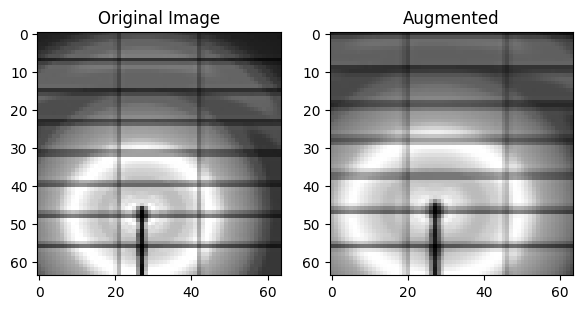

In [30]:
transform = transforms.Compose([
      transforms.ToTensor(),                       # Convert to tensor, channel will be taken care of automatically
      transforms.RandomResizedCrop(64),
])

# Apply transformation
img = images[0]
img_augmented = transform(img)
plot(img, img_augmented)

#### RandomRotation

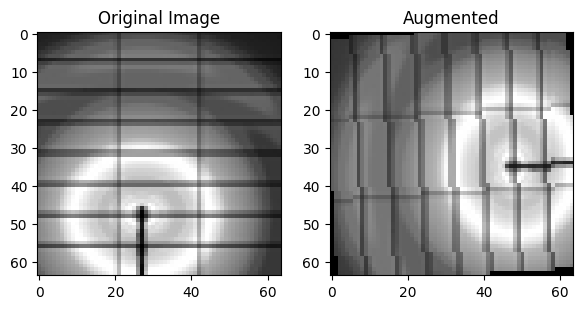

In [31]:
transform = transforms.Compose([
      transforms.ToTensor(),                       # Convert to tensor, channel will be taken care of automatically
      transforms.RandomRotation(degrees=(0, 180)),
])

# Apply transformation
img = images[0]
img_augmented = transform(img)
plot(img, img_augmented)

#### Flipping

Run below cells a few time to take a look.

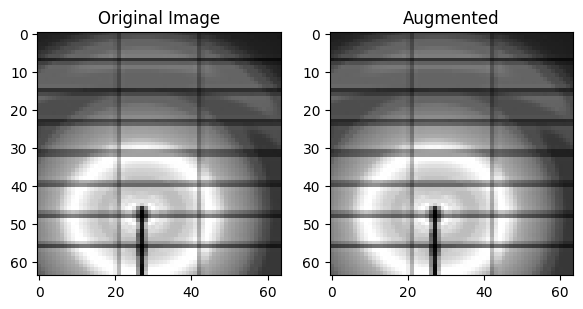

In [32]:
transform = transforms.Compose([
      transforms.ToTensor(),                       # Convert to tensor, channel will be taken care of automatically
      transforms.RandomHorizontalFlip()              # if no arguments are given, it means flip with probability of 0.5
])

# Apply transformation
img = images[0]
img_augmented = transform(img)
plot(img, img_augmented)

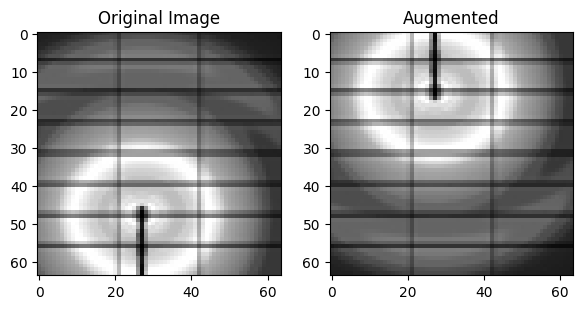

In [33]:
transform = transforms.Compose([
      transforms.ToTensor(),                       # Convert to tensor, channel will be taken care of automatically
      transforms.RandomVerticalFlip()              # if no arguments are given, it means flip with probability of 0.5
])

# Apply transformation
img = images[0]
img_augmented = transform(img)
plot(img, img_augmented)

#### RandomApply

The `RandomApply` transform randomly applies a list of transforms, with a given probability.

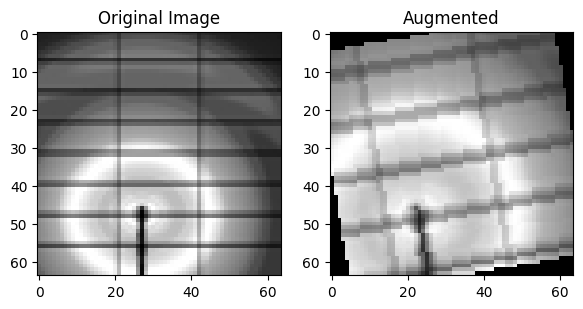

In [34]:
transform = transforms.Compose([
      transforms.ToTensor(),                       # Convert to tensor, channel will be taken care of automatically
      transforms.RandomApply(transforms=[transforms.RandomResizedCrop(64),
                                         transforms.RandomVerticalFlip(),
                                         transforms.RandomRotation(degrees=(0, 180)),
                                         ],
                             p=0.5)
])

# Apply transformation
img = images[0]
img_augmented = transform(img)
plot(img, img_augmented)

Of course there are more options to play with, if you are interested here is a good starting point: [ILLUSTRATION OF TRANSFORMS](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)

#### Example Pipeline to Construct an Augmented Dataset

Below is an example to add the original image and an augmented version into our datset, resulting in doubled size. For simplicity the standardization is omitted.

In [35]:
# Define Data Directory
data_directory = '/content/drive/MyDrive/Code/preprocessing/data_64x64_400/'

# Read filenames
filenames = glob.glob(data_directory + '*.jpg') # '*' is the wildcard which refers to all jpg files within the directory
filenames = sorted(filenames) # This step is not necessary, but if you want the image in your stack to be appeared into a desired order, do so.
print(f'Number of original images: {len(filenames)}')

dataset = [] # A placeholder

for img_name in filenames:
  img = io.imread(img_name) # Read image as numpy array, could use PIL too.

  # Define transformations
  transform1 = transforms.Compose([
      transforms.ToTensor(),                       # Convert to tensor, channel will be taken care of automatically
  ])

  transform2 = transforms.Compose([
      transforms.ToTensor(),
      transforms.RandomResizedCrop(64),
      transforms.RandomRotation(degrees=(0, 180)),
  ])

  # Apply transformation, then append to the dataset list
  img_tensor1 = transform1(img)
  dataset.append(img_tensor1)

  img_tensor2 = transform2(img)
  dataset.append(img_tensor2)

# Stack the dataset to form the 4D array we saw
dataset = torch.stack(dataset)
print(f'Dataset Shape: {dataset.shape}')
dataset = TensorDataset(dataset)


Number of original images: 400
Dataset Shape: torch.Size([800, 1, 64, 64])
